In [1]:
%%html
<style> table {float:left} </style>

In [2]:
import sqlite3
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, pairwise_distances
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

pd.options.mode.chained_assignment = None

### Load the data
The labeled Dataset can only be used by research propose and we can not update it to the Github, if you want to run this code please email Liu Bing liub@uic.edu to get the access of dataset

In [3]:
conn = sqlite3.connect("data/yelpResData.db")
conn.text_factory = lambda x: str(x, 'gb2312', 'ignore')
cursor = conn.cursor()

In [4]:
cursor.execute(
        "SELECT reviewID, reviewerID, restaurantID, date, rating, usefulCount as reviewUsefulCount, reviewContent, flagged FROM review WHERE flagged in ('Y','N')")
review_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])
review_df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged
0,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,9/22/2012,5,0,"Unlike Next, which we'd eaten at the previous ...",N
1,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,9/22/2012,5,0,Probably one of the best meals I've had ever. ...,N
2,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,9/19/2012,3,2,Service was impeccable. Experience and present...,N
3,iSN,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,9/6/2012,3,8,"The problem with places like this, given the e...",N
4,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,9/9/2012,5,1,I have no idea how to write my review - dining...,N


In [5]:
review_df.groupby('reviewID').size()

reviewID
                          1
-                         1
--4L2Rk6                  1
--4Z9JKq2jc4PWxJiG4mrA    1
--AweNX8vPGD              1
                         ..
zzkCzd5jRMUOi5nMUIh9qw    1
zzmNeqmRBX19e             1
zznvKLWkXULv6mVt3R07rA    1
zzq8nU                    1
zzr7OmGfjdxP2hy4tvqm2w    1
Length: 67019, dtype: int64

In [6]:
cursor.execute("SELECT * FROM reviewer")
reviewer_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])
reviewer_df.head()

,reviewerID,name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount
0,bNYesZ944s6IJVowOnB0iA,Scott E.,"Glengary, WV",October 2009,11,48,5,41,5,5,2,0,1
1,TRKxLC3y-ZvP45e5iilMtw,Jerry K.,"Palos Verdes Peninsula, CA",June 2011,0,4,0,0,0,0,0,0,0
2,0EMm8umAqXZzyhxNpL4M9g,Patricia M.,"Chicago, IL",September 2008,2,11,0,6,0,1,0,0,0
3,DlwexC7z88ymAzu45skODw,Terry N.,"San Jose, CA",October 2007,84,60,1,35,8,6,6,11,0
4,kW2dk1CWihmh3g7k9N2G8A,Shradha Vegetarianista A.,"Chicago, IL",July 2007,333,1209,61,1650,679,417,283,22,70


In [7]:
cursor.execute("SELECT restaurantID, rating as restaurantRating FROM restaurant")
restaurant_df = pd.DataFrame(cursor.fetchall(), columns=[column[0] for column in cursor.description])
restaurant_df.head()

,restaurantID,restaurantRating
0,pbEiXam9YJL3neCYHGwLUA,4.5
1,HOJqzz1WvOmeR9oESJ4d9A,4.5
2,AkfSndWBxnTn-LpmiL8aLA,4.5
3,WBU0yq9J8qiYQfI_fh2P1Q,4.0
4,bNXpwTSavHBV9zBk2lUlGA,4.5


In [8]:
# Merge all DataFrames
review_reviewer_df = review_df.merge(reviewer_df, on='reviewerID', how='inner')
df = review_reviewer_df.merge(restaurant_df, on='restaurantID', how='inner')

In [9]:
## Because in the Tripadvior data we can only get the review with "Month-Year", like "Sep-12"
## we change the yelpdataset into same format

In [10]:
for i in range(len(df['date'])):
    if df['date'][i][0] == '\n':
        df['date'][i] = df['date'][i][1:]

df['date'] = df['date'].apply(
    lambda x: datetime.strftime(datetime.strptime(x, '%m/%d/%Y'), '%b-%y'))

In [11]:
df.head()

,reviewID,reviewerID,restaurantID,date,rating,reviewUsefulCount,reviewContent,flagged,name,location,...,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurantRating
0,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,pbEiXam9YJL3neCYHGwLUA,Sep-12,5,0,"Unlike Next, which we'd eaten at the previous ...",N,Scott E.,"Glengary, WV",...,11,48,5,41,5,5,2,0,1,4.5
1,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,pbEiXam9YJL3neCYHGwLUA,Sep-12,5,0,Probably one of the best meals I've had ever. ...,N,Jerry K.,"Palos Verdes Peninsula, CA",...,0,4,0,0,0,0,0,0,0,4.5
2,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,pbEiXam9YJL3neCYHGwLUA,Sep-12,3,2,Service was impeccable. Experience and present...,N,Patricia M.,"Chicago, IL",...,2,11,0,6,0,1,0,0,0,4.5
3,iSN,DlwexC7z88ymAzu45skODw,pbEiXam9YJL3neCYHGwLUA,Sep-12,3,8,"The problem with places like this, given the e...",N,Terry N.,"San Jose, CA",...,84,60,1,35,8,6,6,11,0,4.5
4,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,pbEiXam9YJL3neCYHGwLUA,Sep-12,5,1,I have no idea how to write my review - dining...,N,Shradha Vegetarianista A.,"Chicago, IL",...,333,1209,61,1650,679,417,283,22,70,4.5


In [12]:
list(df.columns)

['reviewID',
 'reviewerID',
 'restaurantID',
 'date',
 'rating',
 'reviewUsefulCount',
 'reviewContent',
 'flagged',
 'name',
 'location',
 'yelpJoinDate',
 'friendCount',
 'reviewCount',
 'firstCount',
 'usefulCount',
 'coolCount',
 'funnyCount',
 'complimentCount',
 'tipCount',
 'fanCount',
 'restaurantRating']

Authentic 20752
Fake 6206


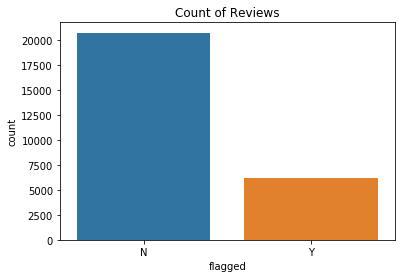

In [13]:
# imbalance data
print("Authentic", len(df[(df['flagged'] == 'N')]))
print("Fake", len(df[(df['flagged'] == 'Y')]))

fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x='flagged', data=df)
plt.title("Count of Reviews")
plt.show()

In [14]:
# output the review data for word2vec modeling

In [15]:
df[['reviewContent']].to_csv("word2vec/restautant_review_corpus.csv",index=False)

### Data preprocessing and Feature Extraction

In [16]:
# Pre-processing Text Reviews
# Remove Stop Words
stop = stopwords.words('english')
df['reviewContent'] = df['reviewContent'].apply(
    lambda x: ' '.join(word for word in x.split() if word not in stop))

# Remove Punctuations
tokenizer = RegexpTokenizer(r'\w+')
df['reviewContent'] = df['reviewContent'].apply(
    lambda x: ' '.join(word for word in tokenizer.tokenize(x)))

# Lowercase Words
df['reviewContent'] = df['reviewContent'].apply(
    lambda x: x.lower())
print("Data Cleaning Complete")

Data Cleaning Complete


In [17]:
df_copy = df.copy()

### Word2Vec glove-100d
We use the glove-twitter-100d word2vec pretrained model

GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

If you want to run the code please down from https://nlp.stanford.edu/projects/glove/  and change it into gensim format, then load the model https://radimrehurek.com/gensim/scripts/glove2word2vec.html

In [18]:
from gensim.models import KeyedVectors
w2vmodel = KeyedVectors.load('word2vec/glove-100d.model')

In [19]:
def get_contentVector(content):
    cutWords = tokenizer.tokenize(content)
    vector_list = [w2vmodel.wv[k] for k in cutWords if k in w2vmodel]
    contentVector = np.array(vector_list).mean(axis=0)
    return pd.Series(contentVector)

In [20]:
train_data_features = df_copy.reviewContent.apply(get_contentVector)
train_data_features

/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.084144,0.008924,0.072401,-0.024843,-0.007080,0.141786,0.091255,-0.074103,0.027709,-0.176506,...,-0.035626,0.222498,0.051498,-0.057887,-0.054126,0.020648,-0.103095,-0.075659,0.041480,0.072034
1,0.141765,0.207773,0.234413,-0.043761,0.000654,0.145734,0.201733,0.111585,0.022794,-0.080799,...,0.056707,0.196300,-0.017508,0.024537,-0.097960,-0.080605,-0.110721,-0.011972,0.114266,-0.244148
2,-0.123290,0.068526,0.066293,0.005036,-0.014015,0.109850,0.255440,-0.075957,0.131502,-0.089424,...,-0.092967,0.238611,0.049966,-0.062526,-0.021822,0.066229,-0.138664,-0.085024,0.078007,-0.165661
3,0.075067,0.010753,0.094559,0.067016,-0.054777,0.162296,0.073667,-0.150416,0.061360,-0.111508,...,-0.048152,0.204064,0.037275,-0.012145,-0.082443,0.008805,-0.080638,-0.111319,0.039832,-0.011517
4,0.049837,0.004028,0.081646,0.067587,0.045614,0.148659,0.179289,-0.162285,0.032707,-0.059238,...,-0.078252,0.174925,0.044389,-0.015281,-0.037578,-0.017072,-0.034766,-0.159711,0.019966,-0.019692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26953,0.026625,0.199872,0.195187,0.141991,0.012617,0.092493,0.231181,0.139785,-0.040430,-0.125180,...,-0.065327,0.088676,-0.027421,0.038431,-0.135566,-0.053532,-0.143536,-0.171461,0.127410,-0.000407
26954,-0.001614,0.042054,0.052811,0.058703,-0.036805,0.062848,0.124824,-0.057469,-0.012216,-0.076118,...,-0.046604,0.115391,0.036704,-0.159428,-0.032223,0.039653,-0.179386,-0.014541,-0.093790,0.039312
26955,0.189181,0.079610,0.029813,0.031000,-0.182015,0.291139,0.064338,0.121546,-0.019083,-0.063416,...,-0.221051,0.199944,-0.094352,0.152009,-0.164242,-0.074402,-0.051681,-0.047223,0.048314,0.091608
26956,0.177052,0.096522,0.073248,-0.072260,-0.081190,0.187631,-0.071591,0.013468,0.054783,-0.008010,...,-0.102369,0.075509,-0.063999,0.043511,-0.049056,-0.013475,-0.003023,-0.181133,0.224108,-0.060496


In [21]:
df_copy = pd.concat([df_copy,train_data_features], axis=1)

In [22]:
print("Feature Engineering: Creating New Features")
# Maximum Number of Reviews per month per reviewer
mnr_df1 = df_copy[['reviewerID', 'date']].copy()
mnr_df2 = mnr_df1.groupby(by=['date', 'reviewerID']).size().reset_index(name='mnr')
mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max()
df_copy = df_copy.merge(mnr_df2, on=['reviewerID', 'date'], how='inner')

# Review Length
df_copy['rl'] = df_copy['reviewContent'].apply(
    lambda x: len(x.split()))

# Review Deviation
df_copy['rd'] = abs(df_copy['rating'] - df_copy['restaurantRating']) / 4

Feature Engineering: Creating New Features


In [23]:
# Maximum cosine similarity
review_data = df_copy

res = OrderedDict()

# Iterate over data and create groups of reviewers
for row in review_data.iterrows():
    if row[1].reviewerID in res:
        res[row[1].reviewerID].append(row[1].reviewContent)
    else:
        res[row[1].reviewerID] = [row[1].reviewContent]

individual_reviewer = [{'reviewerID': k, 'reviewContent': v} for k, v in res.items()]
df2 = dict()
df2['reviewerID'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    # Handle Null/single review gracefully -24-Apr-2019
    try:
        tfidf = vector.fit_transform(reviewer_data['reviewContent'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    # To handle reviewier with just 1 review
    if max == -np.inf:
        max = 0
    df2['reviewerID'][count] = reviewer_data['reviewerID']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['reviewerID', 'Maximum Content Similarity'])

# left outer join on original datamatrix and cosine dataframe -24-Apr-2019
df_copy = pd.merge(review_data, df3, on="reviewerID", how="left")

df_copy.drop(index=np.where(pd.isnull(df_copy))[0], axis=0, inplace=True)
print("Feature Engineering Complete")

/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


Feature Engineering Complete


## Split the dataset into training, testing and validation

### Under-samling data

In [24]:
def under_sampling(df):
    print("Under-Sampling Data")
    # Count of Reviews
    print("Authentic", len(df[(df['flagged'] == 'N')]))
    print("Fake", len(df[(df['flagged'] == 'Y')]))
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x='flagged', data=df)
    plt.title("Count of Reviews")
    plt.show()

    sample_size = len(df[(df['flagged'] == 'Y')])

    authentic_reviews_df = df[df['flagged'] == 'N']
    fake_reviews_df = df[df['flagged'] == 'Y']

    authentic_reviews_us_df = authentic_reviews_df.sample(sample_size)
    under_sampled_df = pd.concat([authentic_reviews_us_df, fake_reviews_df], axis=0)

    print("Under-Sampled Fake", len(under_sampled_df[(under_sampled_df['flagged'] == 'Y')]))
    print("Under-Sampled Authentic", len(under_sampled_df[(under_sampled_df['flagged'] == 'N')]))

    #Graph of Data Distribution
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(x='flagged', data=under_sampled_df)
    plt.title("Count of Reviews")
    plt.show()
    print("Under-Sampling Complete")
    return under_sampled_df

In [25]:
## No undersampling data

In [26]:
_df_copy = df_copy.copy()
labels = _df_copy['flagged']

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/pretrained_model/test_no_sampled.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/pretrained_model/valid_no_sampled.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

# train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/pretrained_model/train_no_sampled.csv",index=False)

In [27]:
## undersampling data

Under-Sampling Data
Authentic 14940
Fake 4467


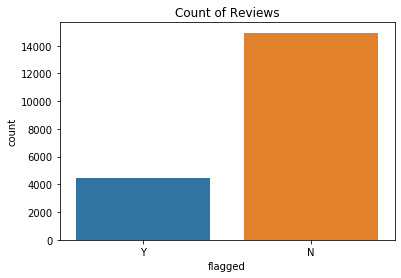

Under-Sampled Fake 4467
Under-Sampled Authentic 4467


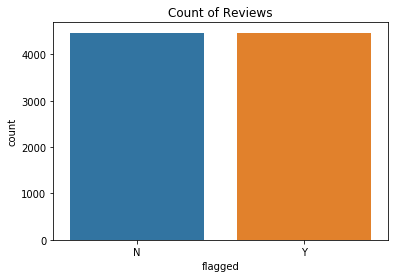

Under-Sampling Complete


In [28]:
_df_copy = df_copy.copy()
labels = _df_copy['flagged']

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/pretrained_model/test.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/pretrained_model/valid.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/pretrained_model/train.csv",index=False)

In [29]:
## undersampling data only word2vec data

Under-Sampling Data
Authentic 14940
Fake 4467


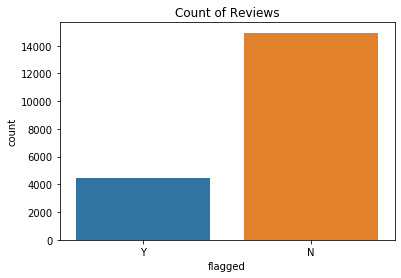

Under-Sampled Fake 4467
Under-Sampled Authentic 4467


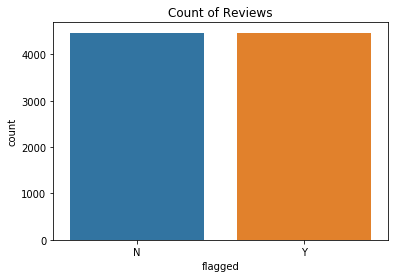

Under-Sampling Complete


In [30]:
_df_copy = df_copy.copy()

labels = _df_copy['flagged']

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount',
        'rating','reviewUsefulCount','mnr','rl','rd','Maximum Content Similarity'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/pretrained_model/test_no_bf.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/pretrained_model/valid_no_bf.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/pretrained_model/train_no_bf.csv",index=False)

In [31]:
## undersampling data only bf data

Under-Sampling Data
Authentic 14940
Fake 4467


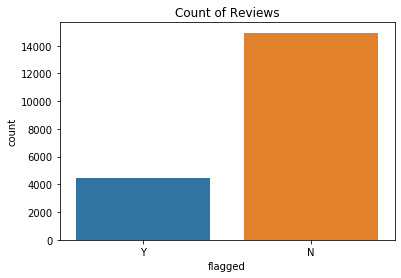

Under-Sampled Fake 4467
Under-Sampled Authentic 4467


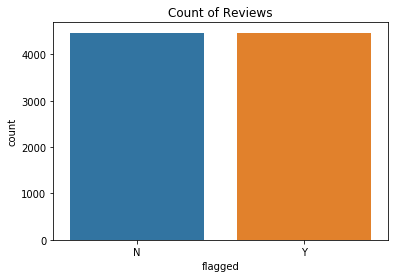

Under-Sampling Complete


In [32]:
_df_copy = df_copy.copy()

labels = _df_copy['flagged']

_df_copy = _df_copy.filter(regex=("^[a-zA-Z]"))

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/pretrained_model/test_bf.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/pretrained_model/valid_bf.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/pretrained_model/train_bf.csv",index=False)

### Word2Vec self-corpus

We only use the corpus in the review data to train a word2vec model with gensim

In [33]:
df_copy = df.copy()

In [34]:
from gensim.models import Word2Vec
w2vmodel = Word2Vec.load("word2vec/plp.w2v.model")

In [35]:
def get_contentVector(content):
    cutWords = tokenizer.tokenize(content)
    vector_list = [w2vmodel.wv[k] for k in cutWords if k in w2vmodel]
    contentVector = np.array(vector_list).mean(axis=0)
    return pd.Series(contentVector)

In [36]:
train_data_features = df_copy.reviewContent.apply(get_contentVector)
train_data_features

/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.244605,-0.259302,0.298896,0.013209,0.107174,0.016789,-0.110925,-0.221564,0.168517,-0.103666,...,0.231464,-0.156435,-0.251519,-0.283007,0.220843,-0.490651,0.297097,0.348498,-0.045630,0.508982
1,0.363722,-0.153034,0.163821,-0.136003,-0.160116,-0.218372,-0.297473,-0.646294,0.389066,0.069423,...,0.348690,-0.149966,0.559680,-0.204930,-0.054161,-0.551071,0.230384,0.340562,-0.236867,0.451799
2,-0.003254,-0.124854,-0.137098,-0.014423,-0.460808,-0.121931,-0.558479,0.242906,0.711618,-0.098454,...,0.177224,0.268653,-0.012598,0.160263,-0.382764,-0.820109,0.164957,0.279889,-0.153710,0.279360
3,0.007156,-0.254948,0.066335,0.072236,-0.046670,-0.087919,-0.305438,-0.271435,0.277427,-0.249265,...,0.142881,-0.015646,0.069136,-0.163269,0.022512,-0.515960,0.041584,0.367039,-0.243894,0.418173
4,0.002647,-0.365544,-0.085578,0.182371,-0.107872,0.020458,-0.445950,-0.329582,0.367194,-0.201117,...,0.083630,-0.027056,0.298724,-0.129631,-0.065105,-0.553074,-0.010449,0.475765,-0.338723,0.364671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26953,-0.189300,-0.309222,-0.128146,0.427264,0.461390,-0.125710,-0.555201,0.019302,0.228583,-0.079300,...,0.150752,0.294588,0.157999,-0.004382,-0.239729,-0.279730,0.060628,0.323661,-0.100624,0.468056
26954,-0.346050,-0.295365,0.091104,0.252665,-0.226341,0.115201,-0.161284,-0.261609,0.328573,-0.073579,...,0.182582,-0.000086,0.295041,0.257525,-0.150545,-0.764264,0.199143,0.367083,-0.039715,0.316847
26955,0.342980,-0.648976,0.017364,0.042128,0.221026,-0.200201,-0.397711,-0.421680,0.436884,-0.584024,...,0.177064,-0.350826,-0.057264,-0.103027,0.213166,-0.773751,0.002077,0.379957,-0.317643,0.392740
26956,-0.098249,-0.269928,0.334943,0.044579,-0.134724,-0.144153,-0.246980,-0.419075,0.540532,-0.305983,...,0.232736,-0.104704,0.244274,-0.037443,-0.128568,-0.419131,-0.073594,0.123329,-0.069586,0.445260


In [37]:
df_copy = pd.concat([df_copy,train_data_features], axis=1)

In [38]:
print("Feature Engineering: Creating New Features")
# Maximum Number of Reviews per month per reviewer
mnr_df1 = df_copy[['reviewerID', 'date']].copy()
mnr_df2 = mnr_df1.groupby(by=['date', 'reviewerID']).size().reset_index(name='mnr')
mnr_df2['mnr'] = mnr_df2['mnr'] / mnr_df2['mnr'].max()
df_copy = df_copy.merge(mnr_df2, on=['reviewerID', 'date'], how='inner')

# Review Length
df_copy['rl'] = df_copy['reviewContent'].apply(
    lambda x: len(x.split()))

# Review Deviation
df_copy['rd'] = abs(df_copy['rating'] - df_copy['restaurantRating']) / 4

Feature Engineering: Creating New Features


In [39]:
# Maximum cosine similarity
review_data = df_copy

res = OrderedDict()

for row in review_data.iterrows():
    if row[1].reviewerID in res:
        res[row[1].reviewerID].append(row[1].reviewContent)
    else:
        res[row[1].reviewerID] = [row[1].reviewContent]

individual_reviewer = [{'reviewerID': k, 'reviewContent': v} for k, v in res.items()]
df2 = dict()
df2['reviewerID'] = pd.Series([])
df2['Maximum Content Similarity'] = pd.Series([])
vector = TfidfVectorizer(min_df=0)
count = -1
for reviewer_data in individual_reviewer:
    count = count + 1
    try:
        tfidf = vector.fit_transform(reviewer_data['reviewContent'])
    except:
        pass
    cosine = 1 - pairwise_distances(tfidf, metric='cosine')

    np.fill_diagonal(cosine, -np.inf)
    max = cosine.max()

    if max == -np.inf:
        max = 0
    df2['reviewerID'][count] = reviewer_data['reviewerID']
    df2['Maximum Content Similarity'][count] = max

df3 = pd.DataFrame(df2, columns=['reviewerID', 'Maximum Content Similarity'])

df_copy = pd.merge(review_data, df3, on="reviewerID", how="left")

df_copy.drop(index=np.where(pd.isnull(df_copy))[0], axis=0, inplace=True)
print("Feature Engineering Complete")

/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/Users/jiachenx/opt/anaconda3/envs/FakeReview/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


Feature Engineering Complete


Under-Sampling Data
Authentic 14940
Fake 4467


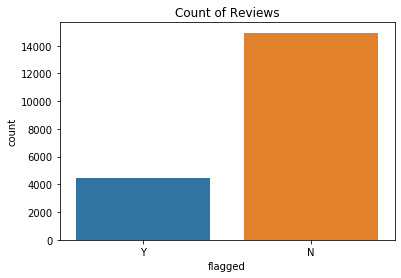

Under-Sampled Fake 4467
Under-Sampled Authentic 4467


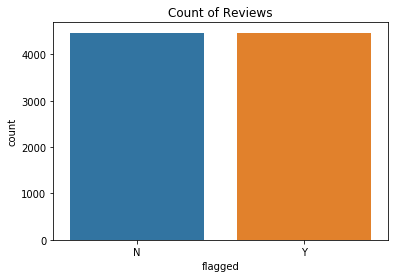

Under-Sampling Complete


In [40]:
_df_copy = df_copy.copy()
labels = _df_copy['flagged']

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/self_model/test.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/self_model/valid.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/self_model/train.csv",index=False)

Under-Sampling Data
Authentic 14940
Fake 4467


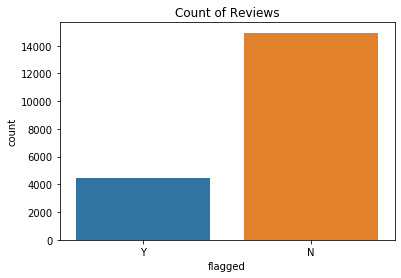

Under-Sampled Fake 4467
Under-Sampled Authentic 4467


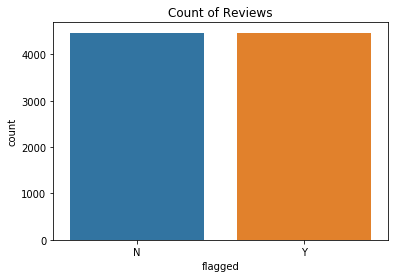

Under-Sampling Complete


In [41]:
_df_copy = df_copy.copy()

labels = _df_copy['flagged']

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount',
        'rating','reviewUsefulCount','mnr','rl','rd','Maximum Content Similarity'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/self_model/test_no_bf.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/self_model/valid_no_bf.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/self_model/train_no_bf.csv",index=False)

Under-Sampling Data
Authentic 14940
Fake 4467


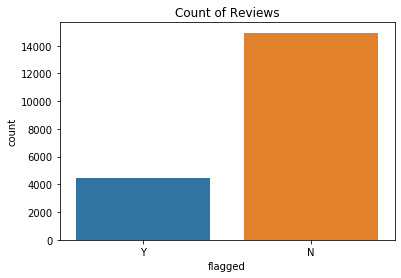

Under-Sampled Fake 4467
Under-Sampled Authentic 4467


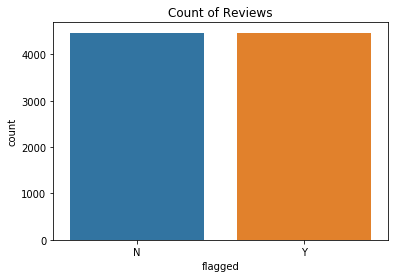

Under-Sampling Complete


In [42]:
_df_copy = df_copy.copy()

labels = _df_copy['flagged']

_df_copy = _df_copy.filter(regex=("^[a-zA-Z]"))

_df_copy.drop(['reviewID', 'reviewerID', 'restaurantID', 'date', 'name', 'location', 'yelpJoinDate', 'flagged','restaurantRating',
         'friendCount','firstCount','usefulCount','coolCount','funnyCount','complimentCount','tipCount','fanCount'], axis=1, inplace=True)

train_data, test_data, train_label, test_label = train_test_split(_df_copy, labels,
                                                                  stratify = labels,
                                                                  test_size=0.2, random_state=42)
train_data, valid_data, train_label, valid_label = train_test_split(train_data, 
                                                                    train_label,
                                                                    stratify = train_label,
                                                                    test_size=0.1, 
                                                                    random_state=42)
test_dataset = pd.concat([test_data,test_label],axis=1)
test_dataset.to_csv("data/self_model/test_bf.csv",index=False)
valid_dataset = pd.concat([valid_data,valid_label],axis=1)
valid_dataset.to_csv("data/self_model/valid_bf.csv",index=False)

train_dataset = pd.concat([train_data,train_label],axis=1)

train_dataset = under_sampling(train_dataset)
train_dataset.to_csv("data/self_model/train_bf.csv",index=False)